# Warm-Up Demo  on TurboGP methods and classes

## 1. Intro

In this notebook we create some random GP trees, visualize them, and perform some genetic operations on them. The purpose of this notebook is to show:
- The different type of abstraction levels for primitives, supported by TurboGP library. We show this by creating different trees, with different primitives' levels enabled.
- How TurboGP classes work (nodes, trees, individuals).
- The usage of different GP operators at different layers of the software library.

This demo is oriented towards people who would like to tinker with TurboGP internal code, understand some of the core concepts of GP or simply to understand the inner workings of the library. In this notebook no evolutionary process is carried, just some individuals are created and visualized.

First, the libraries required to use TurboGP. In general, you will want to use numpy (to process training and testing datasets), matplotlib (to plot fitness and diversity evolution), and networkx (in complement with matplotlib, to graphically visualize GP trees, i.e. generated models)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from six.moves import cPickle as pickle
from networkx.drawing.nx_agraph import graphviz_layout

Then come the files that are part of TurboGP:

In [136]:
from GPIndividuals import *      # where core classes (node, tree) are defined
from GPOperators import *        # where basic crossover and mutation are defined
from GPflavors import *          # where population dynamics (such as steady-state) are defined

from LowLevel import *           # where low-level primitives are defined
from Mezzanine import *          # where mezzanine-level primitives are defined
from HighLevel import *          # where high-level primitives are defined
from Trimmers import *           # where 'trimmers' are defined

from GPUtils import *            # Selection (binary tournament, roulette wheel, elite selection) and migration methods
from Utils import *              # other optional functions

## 2. Low level Individuals

First we will create GP Trees composed of only low-level primitives (such as arithmetic operations, or trigonometric functions). In order to do this, we first need to declare which low-level primitives we wish to use, while leaving empty the set of mezzanine and high level primitives.

In [3]:
# Each of these functions must be properly defined in the corresponding python modules.
lowlevel = ['ADD', 'SUB', 'MUL', 'DIV', 'RELU', 'SIGM', 'X2', 'X3', 'MAX', 'MEAN', 'MIN']
mezzanine = None
highlevel = None

# Now we let the Node objects know the set of input based primitives available at each layer.
Node.f1_set=lowlevel
Node.f2_set=mezzanine
Node.f3_set=highlevel

We also need to make similar declarations regarding terminal types of nodes. For example, within what range scalar constant may take a random value from (i2_set), what trimmers we want to be available (functions that trim large vectorial o matrix inputs / i3_set), and what vector or arraylike constants we will be using (i4_set):

In [4]:
# Each of these trimmer functions also need to be defined in the corresponding python module.
trimmers = ['TFull']

#Node.i1_set=[0,10]              # i1 set (feature variables) is defined for each tree created
Node.i2_set=[-1.0,1.0]           # scalar constant terminals range (-1.0 to 1.0 in this example)
Node.i3_set = trimmers           # Trimmers

Node.i4_set=[]                   # set of constant vector or array-like terminal nodes (masks, prototypes, etc.)    
for _ in range(4):
    # For this set of examples we will simply create a few random 3x3 arrays.
    Node.i4_set.append(np.random.uniform(low=-.1, high=.1, size=(3,3)))

# uncomment to visualize generated constants array
#Node.i4_set

Now we can create a GP tree tha will rely only on low-level primitives. When creating a tree there are two steps:
    1. allocating the variable for the object tree
    2. actually generating (growing) a random tree

In [5]:
# Create a new object of the class tree, specifiying the max allowed depth, and the set of input feature variables:
tree1 = Tree(max_tree_depth=7, i1_set=np.arange(49))
# Generate the tree
tree1.grow_random_tree()

Now that we have generated a tree, we can list its nodes simply by:

In [6]:
tree1.nodes

[(0, SUB, [1, 2]),
 (1, RELU, [3]),
 (2, RELU, [10]),
 (3, MEAN, [4, 5]),
 (4, MAX, [6, 7]),
 (5, MIN, [8, 9]),
 (6, 5, []),
 (7, 40, []),
 (8, -0.5121725912433668, []),
 (9, 20, []),
 (10, MUL, [11, 12]),
 (11, MAX, [13, 14]),
 (12, MUL, [16, 17]),
 (13, RELU, [15]),
 (14, -0.26907279282154595, []),
 (15, 0.6612218272699346, []),
 (16, 30, []),
 (17, 26, [])]

However, it is more interesting and easier to visualize it graphically. We need to create a graph object from the tree and then using networkx/graphviz libraries (along matplotlib) to display it:

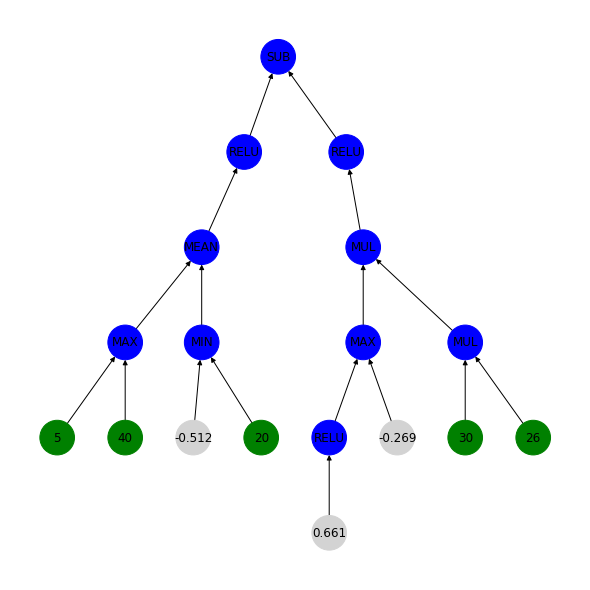

In [8]:
plt.figure(figsize=(8,8))
graph, labels, color_map = get_graph(tree1)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=1200, node_color=color_map)

Tree displayed above only has three types of nodes: low-level function primitives (in blue), scalar constant terminals (in grey), and individual input features (in green).

We can also explore some of the embedded functions trees and node classes have, such as finding out the depth of a subtree rooted at some particular node:

In [9]:
tree1.nodes[3].subtree_depth

2

If we apply such function at the root node, we will get the total depth of the entire tree:

In [10]:
tree1.nodes[0].subtree_depth

5

We can also evaluate the tree, by providing some input vector of the right size. 

In [12]:
# here we pass as input vector = [0,1,2....size], i.e. each feature variable is equal to its index.
tree1.evaluate(np.arange(49).astype(float))

-496.00911156617065

## 2.1 Genetic Operations at core library level

TurboGP provides two basic operations, subtree crossover and subtree mutation, that are used by individuals' classes (see below) to produce offsprings during evolutionary runs. These methods are defined at the core level of the library, in GPOperators file. 

In the case of subtree crossover, there are no safeguards or protection mechanisms that guarantee or verify that produced offsprings do not exceed the max tree depth or that they are valid trees (e.g. that high level primitives are not connected to low level primitives). 

Let's perform some manual crossovers using such method to see how it works.

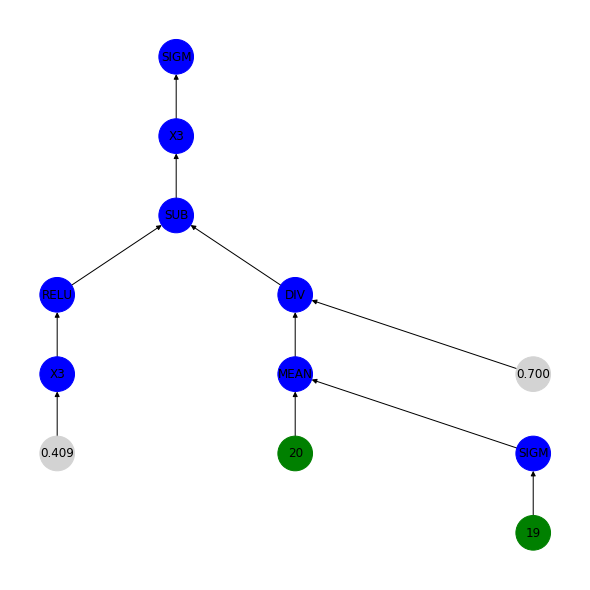

In [24]:
# First lets create a second tree, so we have two parents needed to perform crossover:
tree2 = Tree(max_tree_depth=7, i1_set=np.arange(49))
# Generate the tree
tree2.grow_random_tree()
# and lets visualize it
plt.figure(figsize=(8,8))
graph, labels, color_map = get_graph(tree2)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=1200, node_color=color_map)

In [25]:
tree2.nodes

[(0, SIGM, [1]),
 (1, X3, [2]),
 (2, SUB, [3, 4]),
 (3, RELU, [5]),
 (4, DIV, [7, 8]),
 (5, X3, [6]),
 (6, 0.40873183688894676, []),
 (7, MEAN, [9, 10]),
 (8, 0.7004290300577258, []),
 (9, 20, []),
 (10, SIGM, [11]),
 (11, 19, [])]

Now lets perform a crossover between both trees. At core library level, subtree_crossover method requiere that we specify the nodes that will be the crossover points in each tree. The methods returns as output two new tree objects, the offsprings:

In [26]:
tree3, tree4 = subtree_crossover(tree1, 10, tree2, 4)

Thats it.
Now lets see the results...

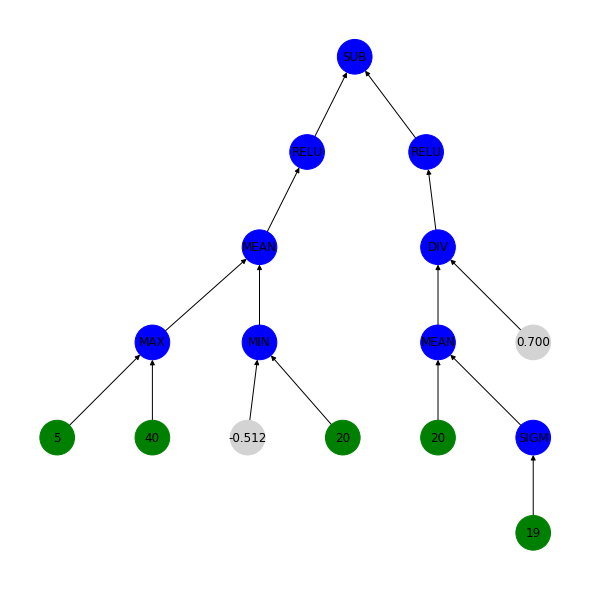

In [28]:
plt.figure(figsize=(8,8))
graph, labels, color_map = get_graph(tree3)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=1200, node_color=color_map)

As we can see, the above tree is very similar to the first tree we created, but with one of its subtrees swaped with a subtree of the second tree.
An analog result we obtain in tree4:

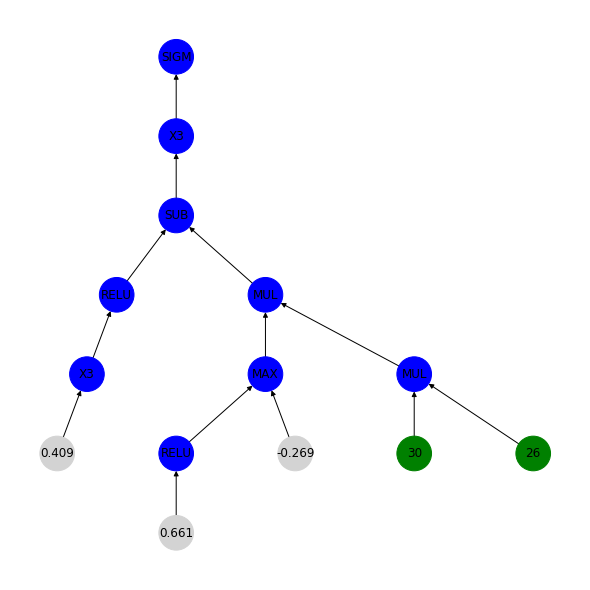

In [29]:
plt.figure(figsize=(8,8))
graph, labels, color_map = get_graph(tree4)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=1200, node_color=color_map)

subtree_crossover is not protected in anyway. So if swap one of the leaf nodes in tree1 with one of the children nodes of tree2's root, and we might get a tree that probably exceeds the max tree depth. 

Now let's see mutation operation.
Mutation only requires as input one tree, and the node at which we want to replace a subtree with a new, randomly, generated one. It returns as output a single new tree.

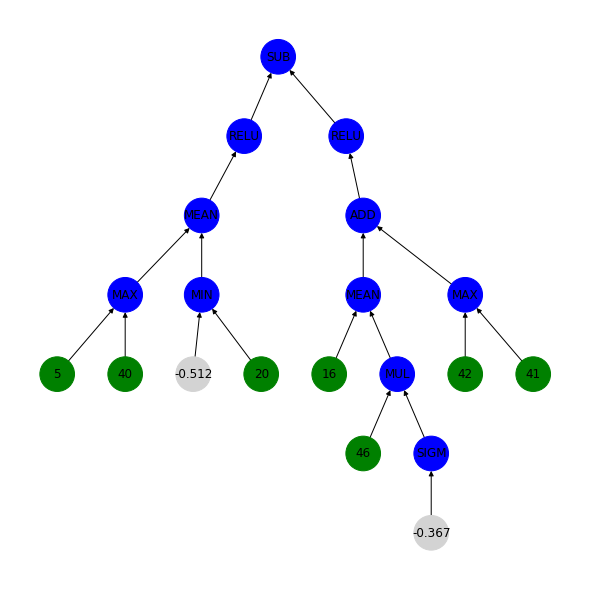

In [33]:
# Make a new tree by mutating a subtree rooted at node 10 in tree1:
tree5 = subtree_mutation(tree1,10)
# Plot it
plt.figure(figsize=(8,8))
graph, labels, color_map = get_graph(tree5)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=1200, node_color=color_map)

Subtree mutation is protected in every way: it will never produce offspring that exceed the max tree deph, and will always produce trees that are syntactically correct, i.e. where layers of different primitives levels are coherent (low level -> mezzanine level -> high level).

## 3. Mezzanine primitives and MidGP models

Mezzanine primitives are those that receive as input a vector or array, and always return as output a single scalar. We call GP models that incorporate both, low- and mezzanine- level function primitives, "Mid-Level GP's" or MidGPs for short.

In order to generate MidGP trees in TurboGP, we just need to enable the mezzanine function we would like to use:

In [34]:
# Remember that these need to be defined in Mezzanine.py file!
mezzanine = ['mMEAN', 'mSTD', 'mMAX', 'mMIN']

# Now we let the Node objects know the set of input based primitives available at each layer.
Node.f2_set=mezzanine

Unlike low-level MEAN, MIN and MAX primitives, which are binary functions, these mezzanine level functions operate over a vector of any size.

We also need to define some 'Trimmers', which are functions that re-shape in some way the input vector or array, so mezzanine levels can operate over different sets of data. We already had done above, but will do it again here, for clarity.

In this case, we will only use one 'Trimmer' which let pass the entire input vector, without any change:

In [35]:
# Trimmers also need to be defined in corresponding file
trimmers = ['TFull']

Node.i3_set = trimmers           # Trimmers

Now when we create a tree, it will be able to use mezzanine level primitives. MidGPs are, more often than not, more powerful than Low-level only GPs (LowGPs), and can be considered as a modern implementation of the GP paradigm in general, when dealing with high dimensional learning problems.

When creating a tree with mezzanine primitives, we need to pass one additional parameter to the constructor: the high_depth_allocation, which specifies what depth of the tree we want to reserve exclusively for low level nodes. Proportion of tree exclusive for low-level nodes = (1 - high_depth_allocation). Setting this parameter to, for example, .4, will avoid that mezzanine nodes apear near the root, which could result in very limited low-level processing.

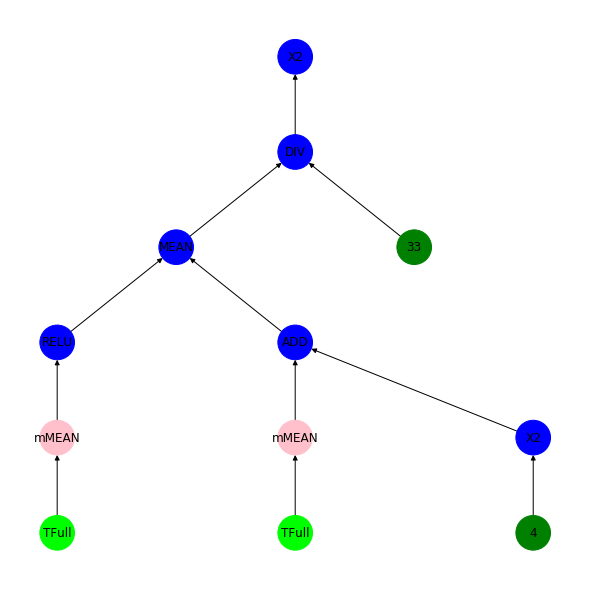

In [50]:
# Create a new tree
MidGP_tree1 = Tree(max_tree_depth=7, i1_set=np.arange(49), grow_method='variable', high_depth_allocation=.4)
# Generate the tree
MidGP_tree1.grow_random_tree()

plt.figure(figsize=(8,8))
graph, labels, color_map = get_graph(MidGP_tree1)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=1200, node_color=color_map)

As we can see, we now have two new types of nodes: mezzanine (in pale pink) and trimmers (in neon green).

Subtree crossover is not protected against producing syntactically invalid trees (e.g. trimmers nodes connected to low level nodes), so we will not perform an example of crossover with MidGP trees.

Subtree mutation, however, is protected in that regard, and can be used safely in this scenario. Let's see an example...

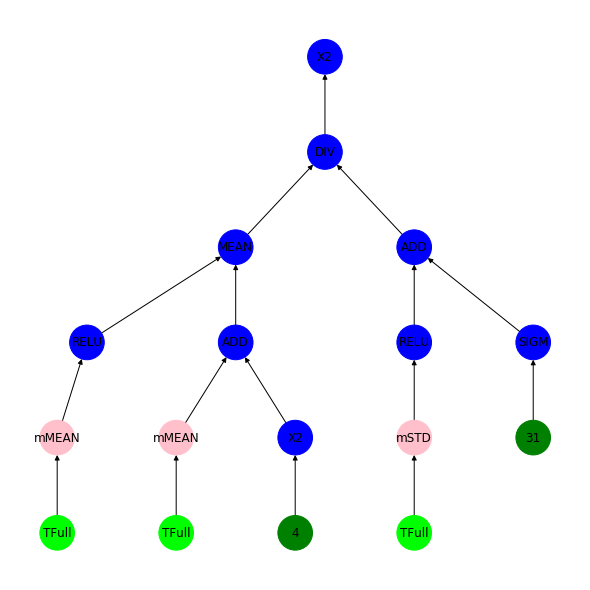

In [84]:
# Make a new tree by mutating a subtree rooted at node 3 in MidGP_tree1:
MidGP_tree2 = subtree_mutation(MidGP_tree1,3)
# Plot it
plt.figure(figsize=(8,8))
graph, labels, color_map = get_graph(MidGP_tree2)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=1200, node_color=color_map)

## 4. High level primitives

High level primitives are those function primitives that receive as input a vector or matrix, and return as output, a vector or matrix as well. High level primitives convey the highest level of abstraction that can generally be found in GP tree nodes (hence the name); as such, they can be as diverse as convolutions or even very specialized image filtering functions on its own.

Just as with mezzanine functions, in TurboGP we just need to declare which high level primitives we wish to use, and make sure they are properly defined in the corresponding file. For this example, we will only use two high level primitives: convolution and max pooling:

In [85]:
highlevel = ['Conv', 'MaxPool']

Node.f3_set=highlevel

We will also need constant terminal nodes that can be used for as inputs for these sort of functions, for example filter masks for the convolution. We had already defined them right at the start of this notebook, so will just see them here:

In [86]:
Node.i4_set

[array([[-0.05936981,  0.03954781, -0.02887502],
        [ 0.0435908 ,  0.017824  ,  0.045253  ],
        [ 0.06502119, -0.02785671,  0.08804559]]),
 array([[ 0.0705713 , -0.04983421, -0.09744477],
        [-0.05258774, -0.06015122, -0.08440751],
        [-0.06838933,  0.04039162, -0.0107534 ]]),
 array([[-0.09941959, -0.07869442,  0.05225227],
        [-0.09002511,  0.08465011, -0.07010563],
        [-0.03304204,  0.09510481, -0.01125924]]),
 array([[-0.08565003, -0.00765965, -0.07698981],
        [ 0.08676762,  0.03626721,  0.00752696],
        [-0.08759819, -0.09353093,  0.05073275]])]

Now, when we create a GP tree, it will be able to make use of all different types of primitives.
For this type of GP trees however, we recommend to use large tree sizes, so both layers of nodes (low level and high level) can have enough space to be allocated.

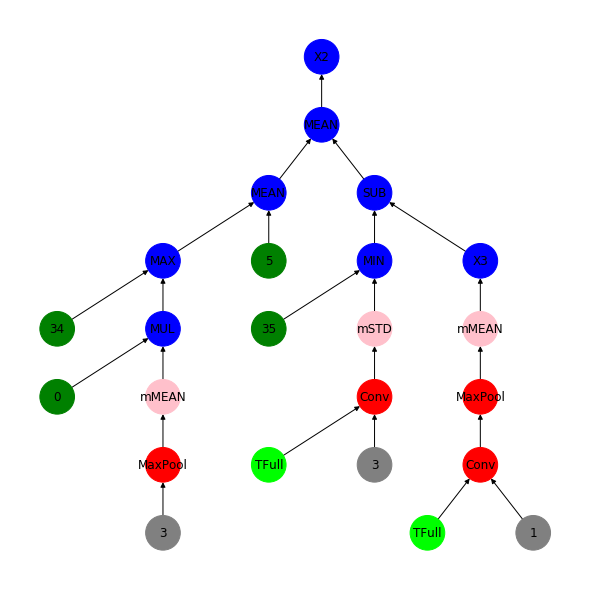

In [115]:
# Create a new tree
HighGP_tree1 = Tree(max_tree_depth=12, i1_set=np.arange(49), grow_method='variable', high_depth_allocation=.6)
# Generate the tree
HighGP_tree1.grow_random_tree()

plt.figure(figsize=(8,8))
graph, labels, color_map = get_graph(HighGP_tree1)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=1200, node_color=color_map)

Now we can see there are two additional types of nodes: high level primitives (red) and constant array-like terminals (dark grey). For example, in the tree shown above, we can see that mask 1 is applied via convolution to the input array, and in another subtree,  mask 3 is applied to the input. 

As with MidGPs, subtree_crossover requires additional enhancements in order to work properly with this kind of individuals; but subtree mutation can be used directly.

## 5. Individuals classes

GP trees alone do not represent a GP-generated model, because they do not have things such a variable that associates to them a fitness value, nor a function that allows to calculate it.

Therefore, in TurboGP what is actually evolved are 'individuals'; these are objects that contain one or more trees, have associated a fitness value, have methods that allow to calculate such fitness value, etc.

Here we will show an example of the most basic individual included in the GP library: SimpleRegresor. As its name implies, it is the type of individual that one would use to evolve a regressor.

In [116]:
from Regressor import *

SimpleRegresor only supports low-level primitives, so lets disable both mezzanine and high level primitives...

In [117]:
mezzanine = None
highlevel = None

Node.f2_set=mezzanine
Node.f3_set=highlevel

Now we can create an object, or Individual, of the SimpleRegresor class. In order to create SimpleRegresor individuals, we need to specify: its input vector size, and the max tree depth for its GP tree,

In [119]:
MyRegressor = SimpleRegresor(input_vector_size=4, complexity=6, grow_method='variable')

Let's see MyRegressor's internal tree:

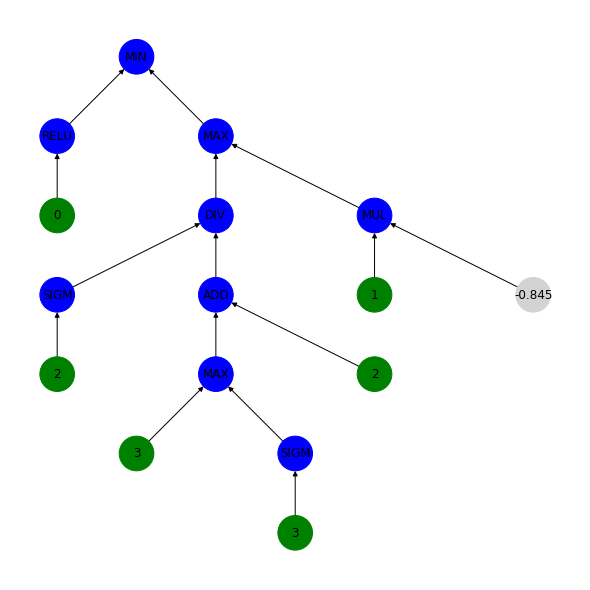

In [121]:
plt.figure(figsize=(8,8))
graph, labels, color_map = get_graph(MyRegressor.tree)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=1200, node_color=color_map)

It also has associated a fitness value:

In [124]:
MyRegressor.fitness_value

inf

(which is inf at time of creation, because SimpleRegressor uses MSE as fitness measure)

## 5.2 Genetic Operations at Individual class level

Another important aspect of Individuals classes, is that they must incorporate genetic operations methods, that rely on the core library methods, but in a simplified and complemented fashion. 

For example, in the case of subtree_mutation, SimpleRegresor incorporates a method that encapsulates the core library method, but it also automatically selects the node to be mutated. In this way, subtree mutation is simply used as:

In [127]:
NewRegressor = SimpleRegresor.mutation(MyRegressor)

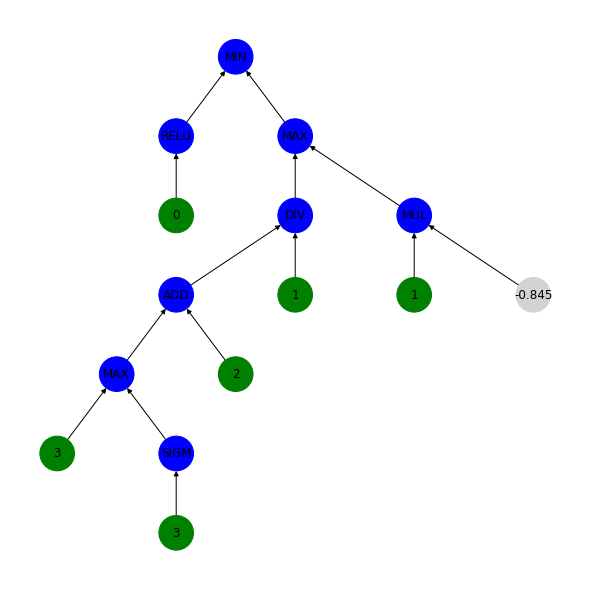

In [128]:
plt.figure(figsize=(8,8))
graph, labels, color_map = get_graph(NewRegressor.tree)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=1200, node_color=color_map)

SimpleRegresor also provides an operation caller 'protected crossover', that, as its name implies, not only encapsulates and simplifies the use of the subtree_crossover method, but also contains the necessary logic to ensure that offspring generated never exceed the max allowed depth.

In [132]:
offspring1, offspring2 =  SimpleRegresor.protected_crossover(MyRegressor, NewRegressor)

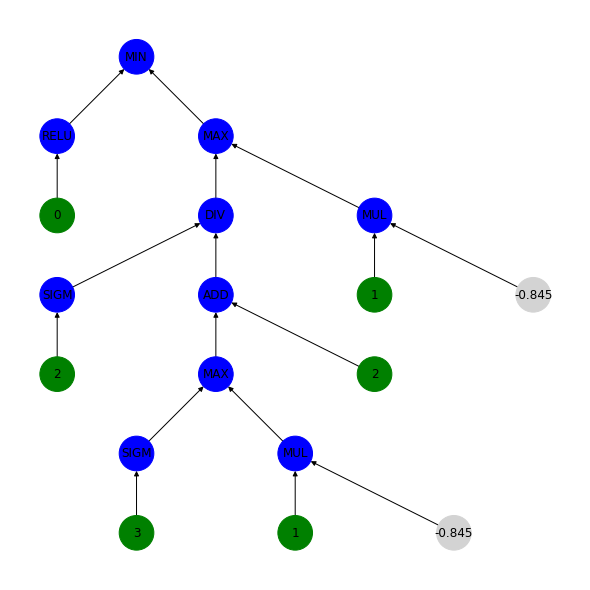

In [133]:
plt.figure(figsize=(8,8))
graph, labels, color_map = get_graph(offspring1.tree)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=1200, node_color=color_map)

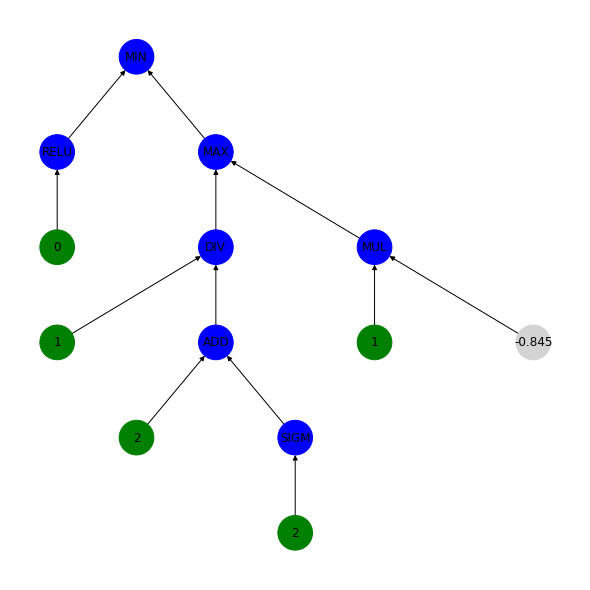

In [134]:
plt.figure(figsize=(8,8))
graph, labels, color_map = get_graph(offspring2.tree)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=1200, node_color=color_map)

When using TurboGP to evolve models, Individuals objects are used, such as SimpleRegresor; Trees and nodes are never manipulated directly, unless you wish to define a new class of individual. For a practical example on the use of TurboGP in a regresssion problem, see notebook 01.